In [3]:
import pandas as pd
from skimage import io, transform, color
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as fn
from torchvision import models
from torchvision.io import read_image
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import dataset, dataloader, Dataset
from torchvision import transforms, utils

In [2]:
%load_ext autoreload
%autoreload 2

In [ ]:
!mkdir -p /content/drive/MyDrive/data/state

In [ ]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip -O /content/drive/MyDrive/data/testSet.zip

In [ ]:
!unzip -q /content/drive/MyDrive/data/testSet.zip -d /content/drive/MyDrive/data/

In [ ]:
!git clone https://github.com/1-1is0/deep-projects

In [ ]:
!cp deep-projects/q2/*.py .

In [4]:
torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
from dataloader import load_data, ImageDataset, Rescale, ToTensor, GetAlexConv
path = "/content/drive/MyDrive/data/tiny-imagenet-200/train/*"
path = "data/tiny-imagenet-200/train/*"

test_df, train_df = load_data(path)
train_dataset = ImageDataset(
    train_df,
    transform=transforms.Compose(
        [
            Rescale((227, 227)),
            ToTensor(),
        ]
    ),
    alexnet_feature=GetAlexConv(layer_number=[2, 2], layer_name="fc6"),
)
test_dataset = ImageDataset(
    test_df,
    transform=transforms.Compose(
        [
            Rescale((227, 227)),
            ToTensor(),
        ]
    ),
    alexnet_feature=GetAlexConv(layer_number=[2, 2], layer_name="fc6"),
)


trainloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64, shuffle=True, num_workers=0
)
testloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=64, shuffle=True, num_workers=0
)

print("train_dataset:", len(train_dataset))
print("test_dataset", len(test_dataset))

train_dataset: 10600
test_dataset 400


In [5]:
from model import AlexFc6
net = AlexFc6().to(device)

print(net)

AlexFc6(
  (fc1): Linear(in_features=4096, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=4096, bias=True)
  (upconv1): ConvTranspose2d(256, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
  (upconv2): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
  (upconv3): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
  (upconv4): ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
  (upconv5): ConvTranspose2d(32, 3, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
)


In [6]:
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR, ExponentialLR

criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

scheduler = ExponentialLR(optimizer, gamma=0.9)



In [7]:
from model import train_model
dataloader = {
    "train": trainloader,
    "val": testloader,
}
dataset_size = {
    "train": len(train_dataset),
    "val": len(test_dataset),
}

res = train_model(data_loader=dataloader, model=net, criterion=criterion, optimizer=optimizer, scheduler=scheduler, device=device, epochs=50, dataset_size=dataset_size)


print(res)



epoch 0 15.416377511891453
epoch 0 13.859056881495885
Finished Training
{'epoch_loss_train': [0.24622354405266897, 0.24466896968228477, 0.24337120992796762, 0.24225736090115138], 'loss_history_train': [172.3564808368683, 171.26827877759933, 170.35984694957733, 169.58015263080597], 'lr': [0.0004782969, 0.00043046721, 0.000387420489, 0.0003486784401], 'epoch_loss_val': [0.24604156494140625, 0.24466521680355072, 0.2435037064552307, 0.24253349542617797], 'loss_history_val': [98.4166259765625, 97.86608672142029, 97.40148258209229, 97.01339817047119]}


In [ ]:
!cp /content/drive/MyDrive/data/state/state-AlexFc6.pth /kaggle/working/

In [44]:
print(res)

{'epoch_loss_train': [0.24622354405266897, 0.24466896968228477], 'loss_history_train': [172.3564808368683, 171.26827877759933], 'lr': [0.0004782969, 0.00043046721], 'epoch_loss_val': [0.24604156494140625, 0.24466521680355072], 'loss_history_val': [98.4166259765625, 97.86608672142029]}


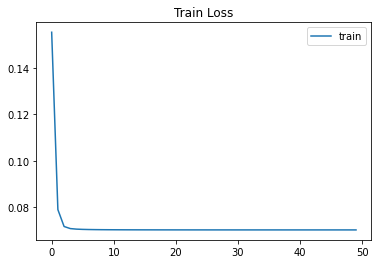

In [26]:
# fig = plt.figure()
plt.plot(np.arange(len(res["epoch_loss_train"])), res["epoch_loss_train"], label="train")
plt.legend()
plt.title("Train Loss")
plt.show()



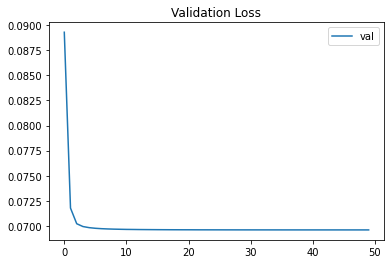

In [27]:

plt.plot(np.arange(len(res["epoch_loss_val"])), res["epoch_loss_val"], label="val")
plt.legend()
plt.title("Validation Loss")
plt.show()


In [29]:


alex = train_dataset[0]["alex"]
net.train(False)
out = net(alex.unsqueeze(0).to(device))

out.size()









torch.Size([1, 4096])


torch.Size([1, 3, 128, 128])

In [31]:
a = out[0, ::, :]
a.size()

torch.Size([3, 128, 128])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


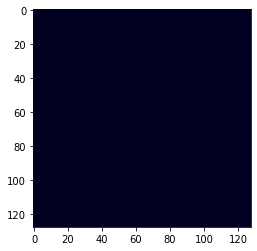

In [32]:
plt.imshow(a.to("cpu").permute(1, 2, 0).detach().numpy())

In [7]:
from model import AlexFc6
model = AlexFc6()
state = torch.load("./state/state-AlexFc6.pth")
model.load_state_dict(state["state_dict"])
# optimizer.load_state_dict(state["optimizer"])
# scheduler.load_state_dict(state["scheduler"])
state_res = state["res"]
state_epoch = state["epoch"]
model.eval()


AlexFc6(
  (fc1): Linear(in_features=4096, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=4096, bias=True)
  (upconv1): ConvTranspose2d(256, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
  (upconv2): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
  (upconv3): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
  (upconv4): ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
  (upconv5): ConvTranspose2d(32, 3, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
)

In [25]:
res = state_res

In [16]:
image = train_dataset[0]["image"]
print(image.shape)
alex = train_dataset[0]['alex']
print(alex.shape)

torch.Size([3, 227, 227])
torch.Size([4096])


In [20]:
ans= model(alex.unsqueeze(0).to('cpu'))

In [21]:
print(ans.shape)

torch.Size([1, 3, 128, 128])


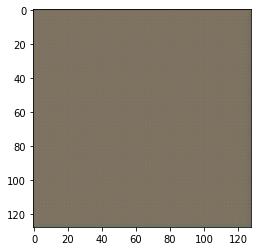

In [23]:
plt.imshow(ans[0, :, :,:].to("cpu").permute(1, 2, 0).detach().numpy())
